# GPT Image Generation with Cost and Time Tracking

This notebook loads an initial image and example image, applies a prompt from a text file to insert/replace objects, and tracks execution time and token costs.

## Setup and Dependencies

# Install required packages

pip install pillow openai -U

In [ ]:
import base64
import os
import time
from datetime import datetime
from openai import OpenAI
from PIL import Image
from io import BytesIO
from IPython.display import Image as IPImage, display
import json

In [ ]:
import os
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

True

In [ ]:
# Initialize OpenAI client
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=OPENAI_API_KEY)

## Configuration and File Paths

In [ ]:
# Directory structure
INPUT_DIR = "inputs"
OUTPUT_DIR = "outputs"
PROMPTS_DIR = "prompts"

# File paths
INITIAL_IMAGE_PATH = os.path.join(INPUT_DIR, "initial.jpg")
EXAMPLE_IMAGE_PATH = os.path.join(INPUT_DIR, "example.jpg")
PROMPT_FILE_PATH = os.path.join(PROMPTS_DIR, "prompt.txt")
OUTPUT_IMAGE_PATH = os.path.join(OUTPUT_DIR, "generated_image.jpg")
RESULTS_LOG_PATH = os.path.join(OUTPUT_DIR, "generation_results.json")

# Create directories if they don't exist
os.makedirs(INPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(PROMPTS_DIR, exist_ok=True)

print(f"Directories created:")
print(f"- Input images: {INPUT_DIR}")
print(f"- Output images: {OUTPUT_DIR}")
print(f"- Prompts: {PROMPTS_DIR}")

Directories created:
- Input images: inputs
- Output images: outputs
- Prompts: prompts


## File Loading Functions

In [ ]:
def load_prompt_from_file(file_path):
    """Load prompt text from a file."""
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            prompt = file.read().strip()
        print(f"✓ Prompt loaded from {file_path}")
        print(f"Prompt length: {len(prompt)} characters")
        return prompt
    except FileNotFoundError:
        print(f"❌ Prompt file not found: {file_path}")
        return None
    except Exception as e:
        print(f"❌ Error loading prompt: {e}")
        return None

def load_and_validate_image(file_path):
    """Load and validate an image file."""
    try:
        with open(file_path, 'rb') as file:
            image_data = file.read()
        
        # Validate that it's a valid image
        image = Image.open(BytesIO(image_data))
        print(f"✓ Image loaded: {file_path}")
        print(f"  - Size: {image.size}")
        print(f"  - Format: {image.format}")
        print(f"  - Mode: {image.mode}")
        
        return open(file_path, 'rb')
    except FileNotFoundError:
        print(f"❌ Image file not found: {file_path}")
        return None
    except Exception as e:
        print(f"❌ Error loading image {file_path}: {e}")
        return None

def display_input_images(initial_path, example_path):
    """Display the input images for reference."""
    print("\n📸 Input Images:")
    
    if os.path.exists(initial_path):
        print("\nInitial Image:")
        display(IPImage(initial_path, width=300))
    
    if os.path.exists(example_path):
        print("\nExample Object Image:")
        display(IPImage(example_path, width=300))

## Cost and Time Tracking Functions

In [ ]:
def estimate_tokens(text):
    """Rough estimation of tokens (approximately 4 characters per token)."""
    return len(text) // 4

def calculate_image_cost(model="gpt-image-1", size="1024x1024", quality="auto"):
    """Calculate estimated cost based on OpenAI pricing.
    Note: Update these prices based on current OpenAI pricing."""
    
    # Estimated pricing (update with actual GPT Image pricing)
    pricing = {
        "gpt-image-1": {
            "1024x1024": {"low": 0.02, "medium": 0.04, "high": 0.06, "auto": 0.04},
            "1536x1024": {"low": 0.03, "medium": 0.06, "high": 0.09, "auto": 0.06},
            "1024x1536": {"low": 0.03, "medium": 0.06, "high": 0.09, "auto": 0.06}
        }
    }
    
    try:
        return pricing[model][size][quality]
    except KeyError:
        return 0.04  # Default estimate

def log_results(results, file_path):
    """Save results to a JSON file."""
    try:
        with open(file_path, 'w', encoding='utf-8') as file:
            json.dump(results, file, indent=2, default=str)
        print(f"✓ Results logged to {file_path}")
    except Exception as e:
        print(f"❌ Error logging results: {e}")

## Load Input Files

In [ ]:
# Load prompt from file
prompt = load_prompt_from_file(PROMPT_FILE_PATH)

if prompt:
    print(f"\n📝 Loaded Prompt Preview:")
    print(f"{prompt[:200]}{'...' if len(prompt) > 200 else ''}")
else:
    print("\n⚠️  Creating example prompt file...")
    example_prompt = """Transform the initial image by inserting the object from the example image. 
The object should be naturally integrated into the scene, maintaining proper lighting, shadows, and perspective. 
Ensure the object looks realistic and fits seamlessly with the existing environment in the initial image. 
Preserve the overall composition and style of the original image while adding the new element."""
    
    with open(PROMPT_FILE_PATH, 'w', encoding='utf-8') as f:
        f.write(example_prompt)
    
    prompt = example_prompt
    print(f"✓ Example prompt created at {PROMPT_FILE_PATH}")

✓ Prompt loaded from prompts/prompt.txt
Prompt length: 16671 characters

📝 Loaded Prompt Preview:
## According to this prompt, generate an image same as the first image, but with the fence replaced by the fence model we want to overlay onto the first image.

The second image is attached as a refer...



🖼️  Loading Images...

📸 Input Images:

Initial Image:


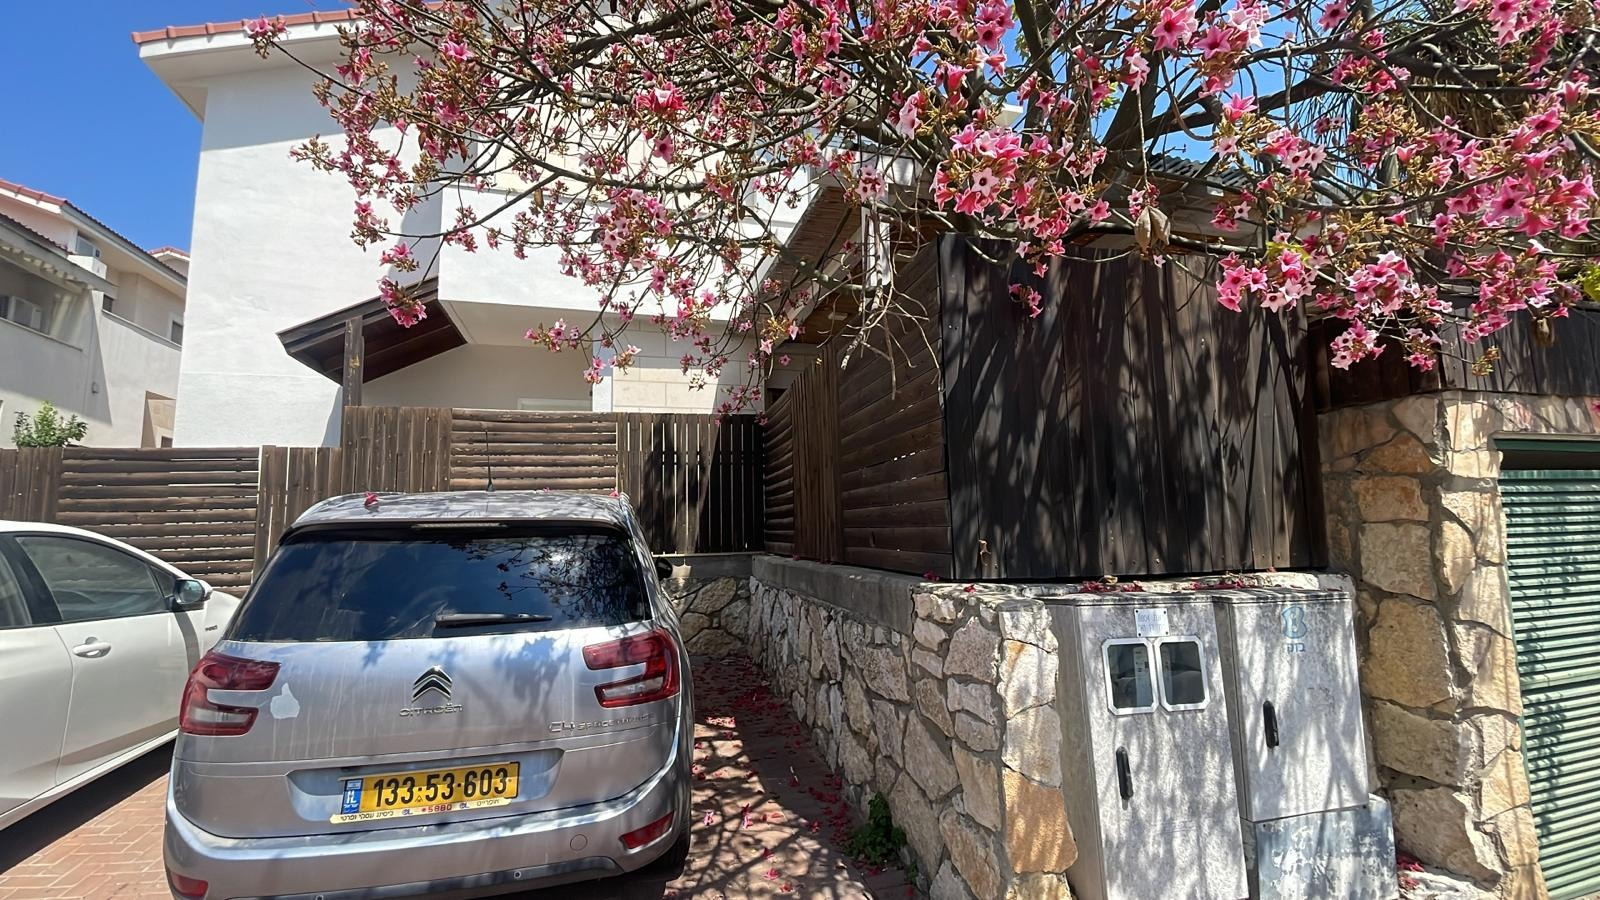


Example Object Image:


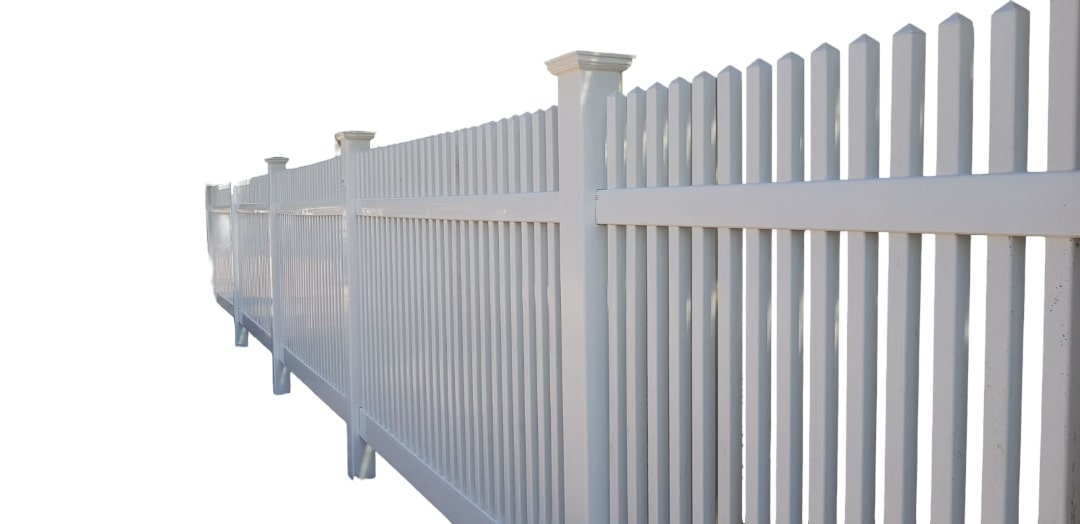

✓ Image loaded: inputs/initial.jpg
  - Size: (1600, 900)
  - Format: JPEG
  - Mode: RGB
✓ Image loaded: inputs/example.jpg
  - Size: (1080, 524)
  - Format: JPEG
  - Mode: RGB


In [ ]:
# Load images
print("\n🖼️  Loading Images...")

# Display input images if they exist
display_input_images(INITIAL_IMAGE_PATH, EXAMPLE_IMAGE_PATH)

# Load image files for API
initial_image = load_and_validate_image(INITIAL_IMAGE_PATH)
example_image = load_and_validate_image(EXAMPLE_IMAGE_PATH)

if not initial_image or not example_image:
    print("\n⚠️  Missing image files. Please add:")
    print(f"- Initial image: {INITIAL_IMAGE_PATH}")
    print(f"- Example object image: {EXAMPLE_IMAGE_PATH}")
    print("\nThe notebook will continue with placeholder functionality.")

## Image Generation with Tracking

In [ ]:
def generate_image_with_tracking(client, prompt, initial_image, example_image, 
                                model="gpt-image-1", quality="auto"):
    """Generate image with time and cost tracking."""
    
    # Initialize tracking
    start_time = time.time()
    timestamp = datetime.now().isoformat()
    
    size = 'auto'
    
    print(f"🚀 Starting image generation...")
    print(f"📅 Timestamp: {timestamp}")
    print(f"🎯 Model: {model}")
    print(f"📏 Size: {size}")
    print(f"💎 Quality: {quality}")
    
    # Estimate costs
    estimated_tokens = estimate_tokens(prompt)
    estimated_cost = calculate_image_cost(model, size, quality)
    
    print(f"💰 Estimated cost: ${estimated_cost:.4f}")
    print(f"🔤 Estimated tokens: {estimated_tokens}")
    
    try:
        # Generate the image
        print("\n⏳ Generating image...")
        
        result = client.images.edit(
            model=model,
            image=[initial_image, example_image],
            prompt=prompt,
            size=size,
            quality=quality
        )
        
        end_time = time.time()
        execution_time = end_time - start_time
        
        print(f"✅ Image generated successfully!")
        print(f"⏱️  Execution time: {execution_time:.2f} seconds")
        
        # Compile results
        results = {
            "timestamp": timestamp,
            "model": model,
            "size": size,
            "quality": quality,
            "prompt_length": len(prompt),
            "estimated_tokens": estimated_tokens,
            "estimated_cost_usd": estimated_cost,
            "execution_time_seconds": execution_time,
            "success": True,
            "prompt_preview": prompt[:100] + "..." if len(prompt) > 100 else prompt
        }
        
        return result, results
        
    except Exception as e:
        end_time = time.time()
        execution_time = end_time - start_time
        
        print(f"❌ Error generating image: {e}")
        
        # Compile error results
        results = {
            "timestamp": timestamp,
            "model": model,
            "size": size,
            "quality": quality,
            "prompt_length": len(prompt),
            "estimated_tokens": estimated_tokens,
            "estimated_cost_usd": estimated_cost,
            "execution_time_seconds": execution_time,
            "success": False,
            "error": str(e),
            "prompt_preview": prompt[:100] + "..." if len(prompt) > 100 else prompt
        }
        
        return None, results

## Execute Image Generation

In [ ]:
# Check if we have all required inputs
if prompt and initial_image and example_image:
    print("🎬 All inputs ready. Starting generation...\n")
    
    # Generate the image
    result, tracking_results = generate_image_with_tracking(
        client=client,
        prompt=prompt,
        initial_image=initial_image,
        example_image=example_image,
        model="gpt-image-1",
        quality="auto"
    )
    
    # Log results
    log_results(tracking_results, RESULTS_LOG_PATH)
    
else:
    print("⚠️  Cannot proceed without all required inputs:")
    print(f"- Prompt: {'✓' if prompt else '❌'}")
    print(f"- Initial image: {'✓' if initial_image else '❌'}")
    print(f"- Example image: {'✓' if example_image else '❌'}")
    
    # Create dummy results for demonstration
    tracking_results = {
        "timestamp": datetime.now().isoformat(),
        "model": "gpt-image-1",
        "size": "1024x1024",
        "quality": "auto",
        "success": False,
        "error": "Missing required input files",
        "estimated_cost_usd": 0.0,
        "execution_time_seconds": 0.0
    }
    
    result = None

🎬 All inputs ready. Starting generation...

🚀 Starting image generation...
📅 Timestamp: 2025-06-30T10:10:37.219769
🎯 Model: gpt-image-1
📏 Size: auto
💎 Quality: auto
💰 Estimated cost: $0.0400
🔤 Estimated tokens: 4167

⏳ Generating image...
✅ Image generated successfully!
⏱️  Execution time: 81.18 seconds
✓ Results logged to outputs/generation_results.json


## Save and Display Results


💾 Saving generated image...
✅ Image saved to: outputs/generated_image.jpg

🎨 Generated Image:


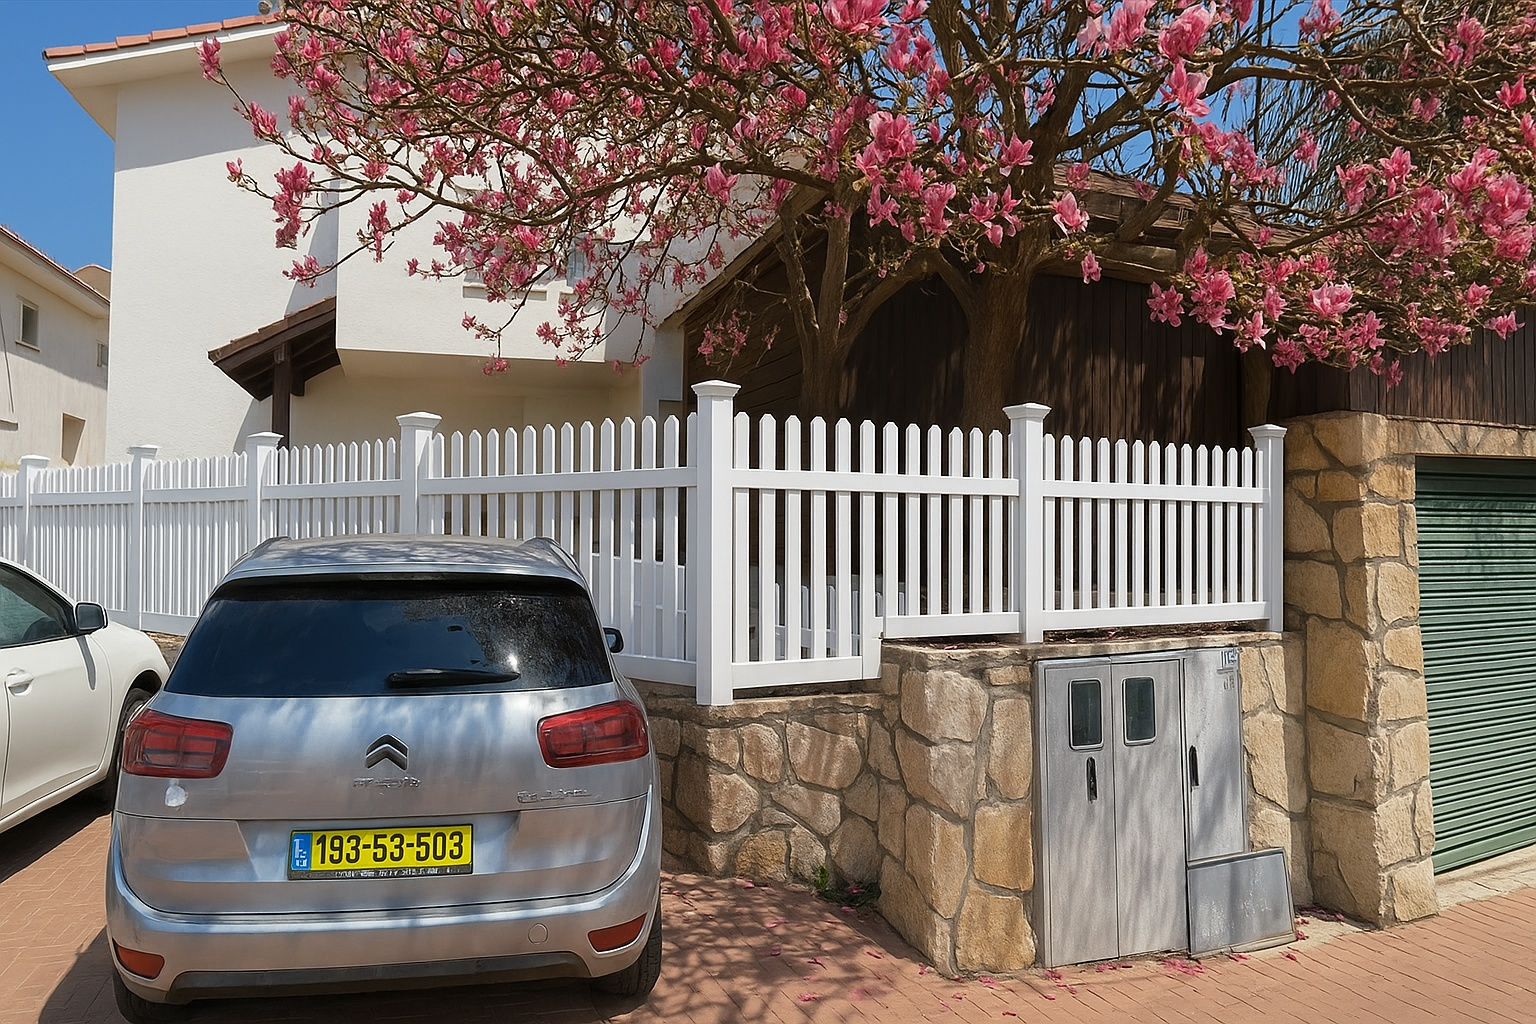

In [ ]:
if result and tracking_results['success']:
    print("\n💾 Saving generated image...")
    
    # Save the generated image
    image_base64 = result.data[0].b64_json
    image_bytes = base64.b64decode(image_base64)
    
    # Save full resolution image
    image = Image.open(BytesIO(image_bytes))
    image.save(OUTPUT_IMAGE_PATH, format="JPEG", quality=95, optimize=True)
    
    print(f"✅ Image saved to: {OUTPUT_IMAGE_PATH}")
    
    # Display the result
    print("\n🎨 Generated Image:")
    display(IPImage(OUTPUT_IMAGE_PATH, width=500))
    
else:
    print("\n❌ No image was generated due to errors or missing inputs.")

## Results Summary

In [ ]:
print("\n📊 GENERATION SUMMARY")
print("=" * 50)

for key, value in tracking_results.items():
    if key == 'prompt_preview':
        print(f"📝 Prompt Preview: {value}")
    elif key == 'execution_time_seconds':
        print(f"⏱️  Execution Time: {value:.2f} seconds")
    elif key == 'estimated_cost_usd':
        print(f"💰 Estimated Cost: ${value:.4f} USD")
    elif key == 'success':
        status = "✅ SUCCESS" if value else "❌ FAILED"
        print(f"🎯 Status: {status}")
    elif key == 'error' and value:
        print(f"❌ Error: {value}")
    elif key not in ['prompt_preview', 'error']:
        print(f"{key.replace('_', ' ').title()}: {value}")

print("\n" + "=" * 50)
print(f"📁 Results logged to: {RESULTS_LOG_PATH}")
if tracking_results['success']:
    print(f"🖼️  Generated image saved to: {OUTPUT_IMAGE_PATH}")


📊 GENERATION SUMMARY
Timestamp: 2025-06-30T10:10:37.219769
Model: gpt-image-1
Size: auto
Quality: auto
Prompt Length: 16671
Estimated Tokens: 4167
💰 Estimated Cost: $0.0400 USD
⏱️  Execution Time: 81.18 seconds
🎯 Status: ✅ SUCCESS
📝 Prompt Preview: ## According to this prompt, generate an image same as the first image, but with the fence replaced ...

📁 Results logged to: outputs/generation_results.json
🖼️  Generated image saved to: outputs/generated_image.jpg


## Cleanup

In [ ]:
# Close file handles
if initial_image:
    initial_image.close()
if example_image:
    example_image.close()

print("🧹 Cleanup completed.")
print("\n✨ Notebook execution finished!")

🧹 Cleanup completed.

✨ Notebook execution finished!


In [ ]:
import requests

# Combine multiple images into one
img1 = Image.open(INITIAL_IMAGE_PATH)
img2 = Image.open(EXAMPLE_IMAGE_PATH)

# Create a combined image (side by side)
combined_width = img1.width + img2.width
combined_height = max(img1.height, img2.height)
combined = Image.new('RGB', (combined_width, combined_height))

COMBINED_IMAGE_PATH = os.path.join(OUTPUT_DIR, 'combined_image.png')

combined.paste(img1, (0, 0))
combined.paste(img2, (img1.width, 0))
combined.save(COMBINED_IMAGE_PATH)

# Prepare the files
files = {
    'image': ("initial.jpg", open(COMBINED_IMAGE_PATH, 'rb'), 'image/png')
}

prompt = open(PROMPT_FILE_PATH, 'r').read().replace('\n', '')

number_of_versions = 1


# Prepare the data
data = {
    'model': 'gpt-image-1',
    'prompt': prompt,
    'n': number_of_versions,
    'size': 'auto'
}

# Prepare headers (don't include Content-Type - requests will set it automatically for multipart)
headers = {
    'Authorization': f"Bearer {OPENAI_API_KEY}"
}


# Make the request
response = requests.post(
    'https://api.openai.com/v1/images/edits',
    headers=headers,
    files=files,
    data=data
)

# Don't forget to close the files
for file_tuple in files.values():
    file_tuple[1].close()



In [ ]:
import base64
import json

# Parse and save the image
if response.status_code != 200:
    raise Exception(f"Request failed with status code {response.status_code}")

# Parse the JSON response
result = response.json()

# Extract the base64 image data
b64_image_data = result['data'][0]['b64_json']

# Decode the base64 data
image_data = base64.b64decode(b64_image_data)

# Save the image to a file
output_filename = 'edited_image.png'
with open(output_filename, 'wb') as f:
    f.write(image_data)

print(f"Image saved as: {output_filename}")

# Optional: Print other response details
print(f"Created: {result['created']}")
print(f"Size: {result['size']}")
print(f"Quality: {result['quality']}")
print(f"Usage: {result['usage']}")

Image saved as: edited_image.png
Created: 1751267593
Size: 1536x1024
Quality: high
Usage: {'input_tokens': 4354, 'input_tokens_details': {'image_tokens': 452, 'text_tokens': 3902}, 'output_tokens': 6208, 'total_tokens': 10562}
